# Imports and Setup

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import segmentation_models_pytorch as smp
from PIL import Image
import torchvision.transforms as T
from collections import defaultdict

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Seed set to 42


Using device: cuda


# Classes and Definitions

In [7]:
class DepthDistillationDataset(Dataset):
    def __init__(self, img_dir, depth_dir, conf_dir, transform=None):
        """
        Args:
            img_dir: Directory with input images
            depth_dir: Directory with teacher depth maps (.npy files)
            conf_dir: Directory with teacher confidence maps (.npy files)
            transform: Optional transform to be applied on images
        """
        self.img_dir = img_dir
        self.depth_dir = depth_dir
        self.conf_dir = conf_dir
        self.transform = transform
        
        # Get list of images
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load teacher predictions (already preprocessed depth maps)
        depth_path = os.path.join(self.depth_dir, img_name.replace('.png', '.npy'))
        teacher_depth = np.load(depth_path)
        
        # Load confidence maps
        conf_path = os.path.join(self.conf_dir, img_name.replace('.png', '.npy'))
        teacher_conf = np.load(conf_path)
        
        # Convert to tensors
        if self.transform:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)
        
        teacher_depth = torch.from_numpy(teacher_depth).float()
        teacher_conf = torch.from_numpy(teacher_conf).float()
        
        return image, teacher_depth, teacher_conf

In [8]:
class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=4, num_workers=2):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def setup(self, stage=None):
        # Datasets are already created globally
        pass
    
    def train_dataloader(self):
        return DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True
        )
    
    def test_dataloader(self):
        return DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True
        )

In [9]:
class DepthDistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.7):
        """
        Args:
            temperature: Temperature for softening teacher predictions
            alpha: Weight for soft loss (1-alpha for hard loss)
        """
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        
    def forward(self, student_pred, teacher_depth, teacher_conf):
        """
        For depth prediction, we use:
        - Soft loss: MSE between student and teacher predictions (weighted by confidence)
        - Hard loss: Direct MSE on depth values
        
        Args:
            student_pred: Student model predictions [B, 1, H, W]
            teacher_depth: Teacher depth maps [B, H, W]
            teacher_conf: Teacher confidence maps [B, H, W]
        """
        # Ensure correct shapes
        if student_pred.dim() == 4:
            student_pred = student_pred.squeeze(1)  # [B, H, W]
        
        # Soft loss: Confidence-weighted MSE with teacher
        # Higher confidence areas have more influence
        soft_loss = self.mse_loss(
            student_pred * teacher_conf, 
            teacher_depth * teacher_conf
        )
        
        # Hard loss: Direct MSE with teacher depth
        hard_loss = self.mse_loss(student_pred, teacher_depth)
        
        # Combined loss
        total_loss = self.alpha * soft_loss + (1 - self.alpha) * hard_loss
        
        return total_loss, soft_loss, hard_loss

In [18]:
class DepthDistillationModule(pl.LightningModule):
    def __init__(self, student_model, lr=3e-4, temperature=4.0, alpha=0.7):
        super().__init__()
        self.student = student_model
        self.lr = lr
        
        self.criterion = DepthDistillationLoss(temperature=temperature, alpha=alpha)
        
        # Track metrics
        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
        # Save hyperparameters
        self.save_hyperparameters(ignore=['student_model'])
    
    def forward(self, x):
        """Forward pass through student model"""
        return self.student(x)
    
    def training_step(self, batch, batch_idx):
        images, teacher_depth, teacher_conf = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        total_loss, soft_loss, hard_loss = self.criterion(
            student_pred, teacher_depth, teacher_conf
        )
        
        # Log metrics
        self.log('train_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_soft_loss', soft_loss, on_step=False, on_epoch=True)
        self.log('train_hard_loss', hard_loss, on_step=False, on_epoch=True)
        
        # Store for epoch end
        self.training_step_outputs['loss'] += total_loss.detach().cpu()
        self.training_step_outputs['soft_loss'] += soft_loss.detach().cpu()
        self.training_step_outputs['hard_loss'] += hard_loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
        
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        images, teacher_depth, teacher_conf = batch
        
        # Get student predictions
        student_pred = self(images)
        
        # Calculate losses
        total_loss, soft_loss, hard_loss = self.criterion(
            student_pred, teacher_depth, teacher_conf
        )
        
        # Log metrics
        self.log('val_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_soft_loss', soft_loss, on_step=False, on_epoch=True)
        self.log('val_hard_loss', hard_loss, on_step=False, on_epoch=True)
        
        # Store for epoch end
        self.validation_step_outputs['loss'] += total_loss.detach().cpu()
        self.validation_step_outputs['soft_loss'] += soft_loss.detach().cpu()
        self.validation_step_outputs['hard_loss'] += hard_loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return total_loss
    
    def on_train_epoch_end(self):
        """Calculate and log average training metrics - NO PRINT STATEMENTS"""
        if self.training_step_outputs['steps'] > 0:
            avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
            avg_soft = self.training_step_outputs['soft_loss'] / self.training_step_outputs['steps']
            avg_hard = self.training_step_outputs['hard_loss'] / self.training_step_outputs['steps']
            
            # Use logging instead of print to avoid recursion
            self.log('train_epoch_loss', avg_loss, prog_bar=False)
            self.log('train_epoch_soft_loss', avg_soft, prog_bar=False)
            self.log('train_epoch_hard_loss', avg_hard, prog_bar=False)
            
        self.training_step_outputs.clear()
    
    def on_validation_epoch_end(self):
        """Calculate and log average validation metrics - NO PRINT STATEMENTS"""
        if self.validation_step_outputs['steps'] > 0:
            avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
            avg_soft = self.validation_step_outputs['soft_loss'] / self.validation_step_outputs['steps']
            avg_hard = self.validation_step_outputs['hard_loss'] / self.validation_step_outputs['steps']
            
            # Use logging instead of print
            self.log('val_epoch_loss', avg_loss, prog_bar=False)
            self.log('val_epoch_soft_loss', avg_soft, prog_bar=False)
            self.log('val_epoch_hard_loss', avg_hard, prog_bar=False)
            
        self.validation_step_outputs.clear()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.student.parameters(), lr=self.lr)
        
        # Optional: Add learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

# Dataset Creation

In [12]:
# Dataset paths
TRAIN_IMG_DIR = '../CamVid/train/'
TRAIN_DEPTH_DIR = '../CamVid/train_labels/train_depths/'
TRAIN_CONF_DIR = '../CamVid/train_labels/train_confs/'

VAL_IMG_DIR = '../CamVid/val/'
VAL_DEPTH_DIR = '../CamVid/val_labels/val_depths/'
VAL_CONF_DIR = '../CamVid/val_labels/val_confs/'

TEST_IMG_DIR = '../CamVid/test/'
TEST_DEPTH_DIR = '../CamVid/test_labels/test_depths/'
TEST_CONF_DIR = '../CamVid/test_labels/test_confs/'

# Define transforms for training and validation
train_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = DepthDistillationDataset(
    img_dir=TRAIN_IMG_DIR,
    depth_dir=TRAIN_DEPTH_DIR,
    conf_dir=TRAIN_CONF_DIR,
    transform=train_transform
)

val_dataset = DepthDistillationDataset(
    img_dir=VAL_IMG_DIR,
    depth_dir=VAL_DEPTH_DIR,
    conf_dir=VAL_CONF_DIR,
    transform=val_transform
)

test_dataset = DepthDistillationDataset(
    img_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
    conf_dir=TEST_CONF_DIR,
    transform=val_transform
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Test dataset
sample_img, sample_depth, sample_conf = train_dataset[0]
print(f"\nSample shapes:")
print(f"Image: {sample_img.shape}")
print(f"Teacher depth: {sample_depth.shape}")
print(f"Teacher confidence: {sample_conf.shape}")

Training samples: 369
Validation samples: 100
Test samples: 232

Sample shapes:
Image: torch.Size([3, 720, 960])
Teacher depth: torch.Size([720, 960])
Teacher confidence: torch.Size([720, 960])


# Training Loop

In [14]:
# Hyperparameters
BATCH_SIZE = 4
NUM_WORKERS = 2
LEARNING_RATE = 3e-4
NUM_EPOCHS = 20
TEMPERATURE = 4.0
ALPHA = 0.7  # Weight for soft loss vs hard loss

In [19]:
# Create student model using segmentation_models_pytorch
student = smp.Unet(
    encoder_name="resnet18",        # ResNet18 backbone
    encoder_weights="imagenet",     # Use pretrained weights
    in_channels=3,                  # RGB input
    classes=1,                      # Single channel output (depth)
    activation=None                 # No activation (regression task)
)

print("Student model created successfully!")
print(f"Student parameters: {sum(p.numel() for p in student.parameters()):,}")

# Create Lightning module
lightning_module = DepthDistillationModule(
    student_model=student,
    lr=LEARNING_RATE,
    temperature=TEMPERATURE,
    alpha=ALPHA
)

# Create data module
data_module = DataModule(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Setup logger
csv_logger = CSVLogger(
    save_dir=os.getcwd(),
    name="depth_distillation_resnet18"
)

# Setup checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    filename='best_model',
    save_top_k=1,
    verbose=True
)

print("Training components initialized!")

# Create trainer
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    logger=csv_logger,
    callbacks=[checkpoint_callback],
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision=16,  # Use mixed precision for faster training
    gradient_clip_val=1.0,  # Gradient clipping for stability
    log_every_n_steps=10
)

print(f"Trainer configured for {NUM_EPOCHS} epochs")
print(f"Using: {trainer.accelerator}")

# Train the model
trainer.fit(lightning_module, data_module)

print("\nTraining completed!")
print(f"Best model saved at: {checkpoint_callback.best_model_path}")
print(f"Best validation loss: {checkpoint_callback.best_model_score:.4f}")

Using 16bit Automatic Mixed Precision (AMP)


Student model created successfully!
Student parameters: 14,328,209
Training components initialized!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer configured for 20 epochs
Using: <pytorch_lightning.accelerators.cuda.CUDAAccelerator object at 0x7d85ed210690>


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ student   │ Unet                  │ 14.3 M │ train │     0 │
│ 1 │ criterion │ DepthDistillationLoss │      0 │ train │     0 │
└───┴───────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 14.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.3 M                                                                                               
Total estimated model params size (MB): 57                                                                         
Modules in train mode: 142                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Epoch 0, global step 93: 'val_loss' reached 5485.48145 (best 5485.48145), saving model to '/home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/depth_distillation_resnet18/version_2/checkpoints/best_model.ckpt' as top 1
Epoch 1, global step 186: 'val_loss' reached 3907.75366 (best 3907.75366), saving model to '/home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/depth_distillation_resnet18/version_2/checkpoints/best_model.ckpt' as top 1
Epoch 2, global step 279: 'val_loss' reached 3615.66260 (best 3615.66260), saving model to '/home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/depth_distillation_resnet18/version_2/checkpoints/best_model.ckpt' as top 1
Epoch 3, global step 372: 'val_loss' reached 3028.53003 (best 3028.53003), saving model to '/home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/depth_distillation_resnet18/version_2/checkpoints/best_model.ckpt' as top 1
Epoch 4, global step 465: 'val_loss' reached 2386


Training completed!
Best model saved at: /home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/depth_distillation_resnet18/version_2/checkpoints/best_model.ckpt
Best validation loss: 173.0937


# Load Best Model

In [20]:
# Load best model
best_model = DepthDistillationModule.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    student_model=student
)
best_model.eval()

print("Best model loaded for evaluation!")

Best model loaded for evaluation!


# Visualize Test Predictions

Visualizing predictions on TEST set:


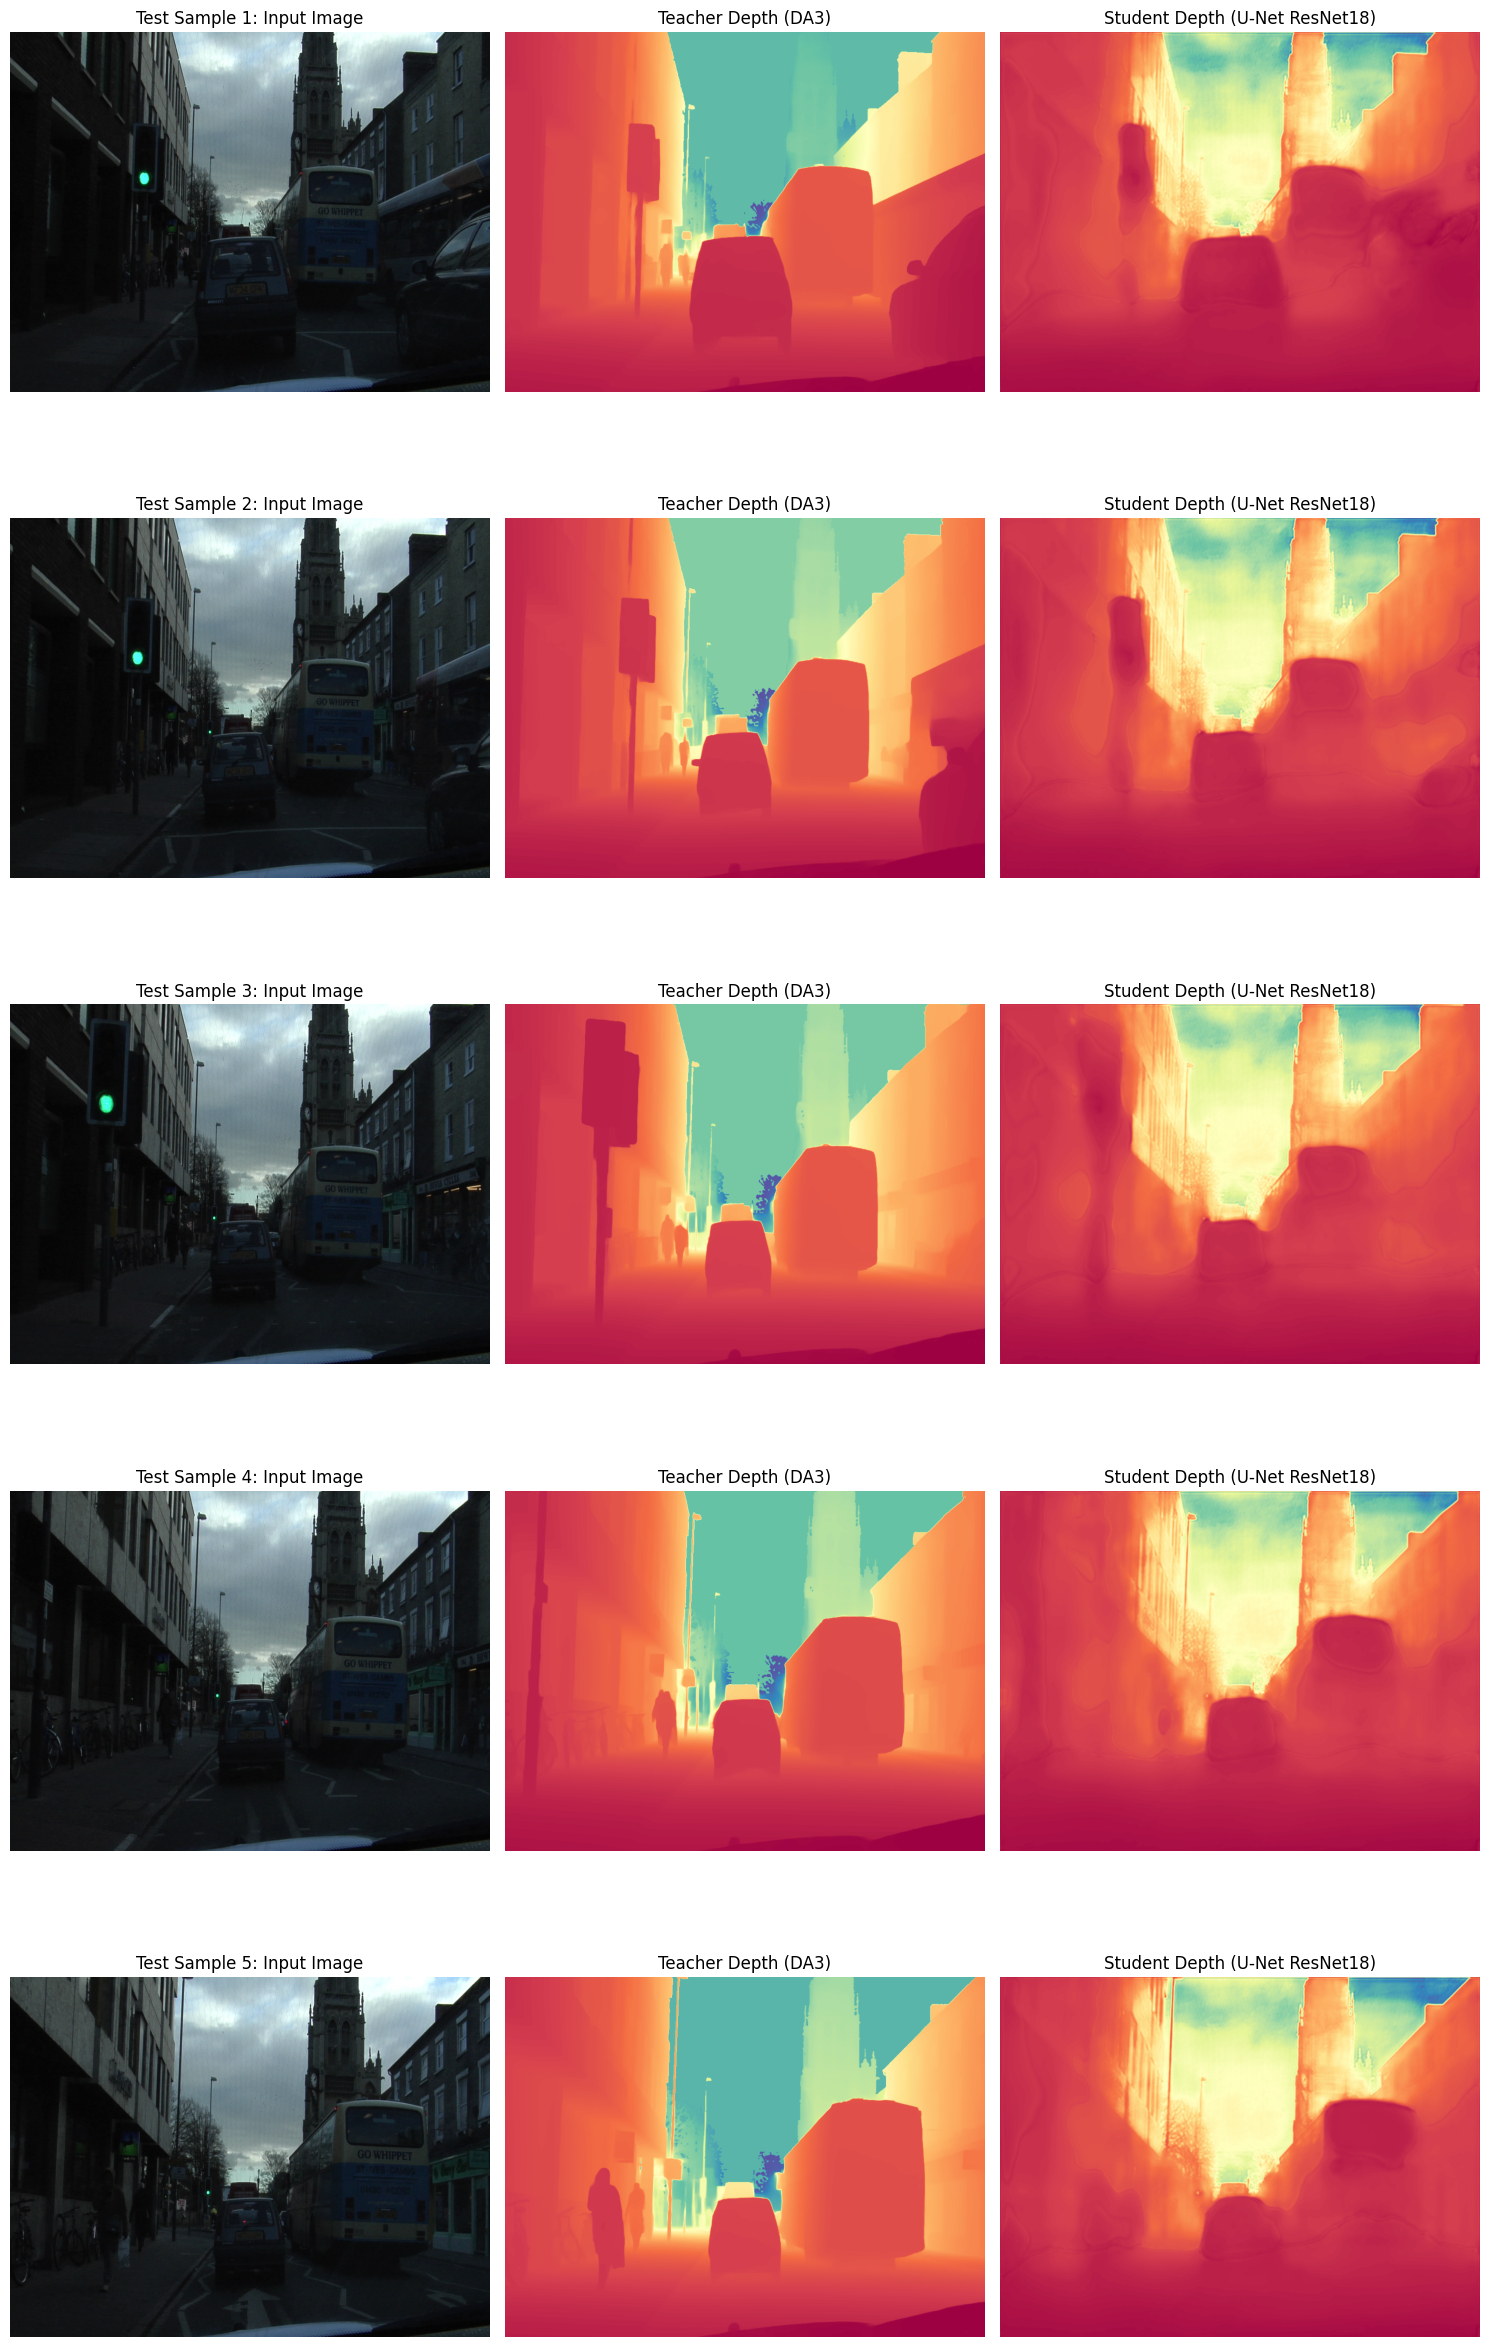

In [21]:
def visualize_predictions(model, dataset, num_samples=5, title_prefix="Test"):
    """Visualize student predictions vs teacher depth maps"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, teacher_depth, teacher_conf = dataset[i]
            
            # Get student prediction
            student_pred = model(image.unsqueeze(0).to(device))
            student_pred = student_pred.squeeze().cpu().numpy()
            
            # Denormalize image for visualization
            img_display = image.clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_display = img_display * std + mean
            img_display = torch.clamp(img_display, 0, 1)
            
            # Plot
            axes[i, 0].imshow(img_display.permute(1, 2, 0))
            axes[i, 0].set_title(f'{title_prefix} Sample {i+1}: Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
            axes[i, 1].set_title('Teacher Depth (DA3)')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(student_pred, cmap='Spectral')
            axes[i, 2].set_title('Student Depth (U-Net ResNet18)')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{title_prefix.lower()}_depth_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizing predictions on TEST set:")
visualize_predictions(best_model.student, test_dataset, num_samples=5, title_prefix="Test")

# Calculate Metrics

In [22]:
def calculate_metrics(model, dataloader, split_name="Test"):
    """Calculate depth estimation metrics"""
    model.eval()
    
    total_mse = 0
    total_mae = 0
    total_abs_rel = 0  # Additional metric: absolute relative error
    num_samples = 0
    
    with torch.no_grad():
        for images, teacher_depth, _ in dataloader:
            images = images.to(device)
            teacher_depth = teacher_depth.to(device)
            
            # Get predictions
            student_pred = model(images).squeeze(1)
            
            # Calculate metrics
            mse = F.mse_loss(student_pred, teacher_depth)
            mae = F.l1_loss(student_pred, teacher_depth)
            
            # Absolute relative error
            abs_rel = torch.mean(torch.abs(student_pred - teacher_depth) / (teacher_depth + 1e-8))
            
            total_mse += mse.item() * images.size(0)
            total_mae += mae.item() * images.size(0)
            total_abs_rel += abs_rel.item() * images.size(0)
            num_samples += images.size(0)
    
    metrics = {
        'MSE': total_mse / num_samples,
        'MAE': total_mae / num_samples,
        'RMSE': np.sqrt(total_mse / num_samples),
        'Abs Rel': total_abs_rel / num_samples
    }
    
    print(f"\n{split_name} Set Metrics:")
    print("=" * 40)
    for metric_name, value in metrics.items():
        print(f"  {metric_name:12s}: {value:.4f}")
    print("=" * 40)
    
    return metrics

# Calculate metrics on TEST set
test_loader = data_module.test_dataloader()
test_metrics = calculate_metrics(best_model.student, test_loader, split_name="Test")

# Also calculate on validation for comparison
val_loader = data_module.val_dataloader()
val_metrics = calculate_metrics(best_model.student, val_loader, split_name="Validation")


Test Set Metrics:
  MSE         : 183.3943
  MAE         : 7.5133
  RMSE        : 13.5423
  Abs Rel     : 0.1601

Validation Set Metrics:
  MSE         : 101.8742
  MAE         : 5.4391
  RMSE        : 10.0933
  Abs Rel     : 0.1241


# Comparison

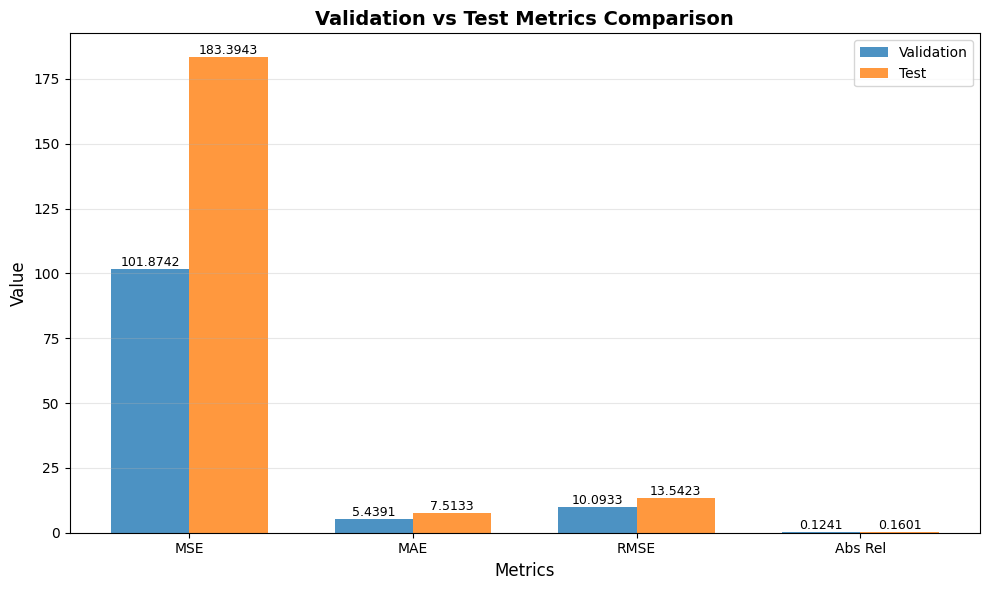

In [23]:
def plot_metric_comparison(test_metrics, val_metrics):
    """Compare test vs validation metrics"""
    metrics_names = list(test_metrics.keys())
    test_values = [test_metrics[m] for m in metrics_names]
    val_values = [val_metrics[m] for m in metrics_names]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, val_values, width, label='Validation', alpha=0.8)
    bars2 = ax.bar(x + width/2, test_values, width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title('Validation vs Test Metrics Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot comparison
plot_metric_comparison(test_metrics, val_metrics)

# Test Set Detailed Analysis

In [24]:
def detailed_test_analysis(model, dataset, num_samples=10):
    """Perform detailed analysis on test samples"""
    model.eval()
    
    errors = []
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, teacher_depth, _ = dataset[i]
            
            # Get prediction
            student_pred = model(image.unsqueeze(0).to(device))
            student_pred = student_pred.squeeze().cpu()
            
            # Calculate per-sample error
            mse = F.mse_loss(student_pred, teacher_depth).item()
            mae = F.l1_loss(student_pred, teacher_depth).item()
            
            errors.append({
                'sample_idx': i,
                'MSE': mse,
                'MAE': mae
            })
    
    # Print per-sample results
    print("\nPer-Sample Test Results:")
    print("-" * 50)
    for error in errors:
        print(f"Sample {error['sample_idx']:3d}: MSE={error['MSE']:.4f}, MAE={error['MAE']:.4f}")
    
    # Statistical summary
    mse_values = [e['MSE'] for e in errors]
    mae_values = [e['MAE'] for e in errors]
    
    print("\nStatistical Summary:")
    print("-" * 50)
    print(f"MSE - Mean: {np.mean(mse_values):.4f}, Std: {np.std(mse_values):.4f}")
    print(f"MAE - Mean: {np.mean(mae_values):.4f}, Std: {np.std(mae_values):.4f}")

# Run detailed analysis
detailed_test_analysis(best_model.student, test_dataset, num_samples=10)


Per-Sample Test Results:
--------------------------------------------------
Sample   0: MSE=101.7383, MAE=6.1341
Sample   1: MSE=119.1738, MAE=6.6022
Sample   2: MSE=141.9300, MAE=7.6747
Sample   3: MSE=144.0683, MAE=6.8844
Sample   4: MSE=145.5139, MAE=7.1762
Sample   5: MSE=106.4998, MAE=6.0860
Sample   6: MSE=94.6828, MAE=6.2417
Sample   7: MSE=144.6272, MAE=7.7343
Sample   8: MSE=214.9075, MAE=9.9792
Sample   9: MSE=166.6352, MAE=9.2143

Statistical Summary:
--------------------------------------------------
MSE - Mean: 137.9777, Std: 33.8014
MAE - Mean: 7.3727, Std: 1.2549
